In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
states = ShapelyFeature(Reader('/glade/work/mazrooei/DATA/useful_shapefiles/states.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')
proj = ccrs.Orthographic(central_longitude=-100, central_latitude=35)
ncproj = ccrs.PlateCarree()
# Define the projection of NWM
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0))
extent_conus = [-122, -73, 22, 50]


In [20]:
%%time
list_basins = pd.read_csv('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/data/basin_list.txt', dtype=str, names=['site_no']).site_no.to_list()
LSTM_aorc = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_SplitSamplingTest1_seed588170_aorc_gagesII_trained_on_2005_2020/ealstm_EvalBasins_2005_2020.p')
LSTM_c404 = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_seed588170_aorc_gagesII_trained_on_2005_2020/ealstm_eval_2005_2020.p')

usgs_meta = pd.read_csv("/glade/p/cisl/nwc/nwm_verification_obs/streamflow_usgs/obsStrMeta.csv", dtype={'site_no': str}, index_col=0).set_index('site_no')
usgs_meta = usgs_meta.sort_index()
usgs_short_columns = ['station_nm', 'dec_lat_va', 'dec_long_va']
usgs_short = usgs_meta[usgs_short_columns]


CPU times: user 785 ms, sys: 32 ms, total: 817 ms
Wall time: 951 ms


In [5]:
def my_verif(obs, sim):
    # sim = df.qsim
    # obs = df.qobs

    sim_log = np.log(sim+0.0001)
    sim_mean = np.mean(sim)
    sim_std = np.std(sim)
    
    obs_log = np.log(obs+0.0001)
    obs_mean = np.mean(obs)
    obs_std = np.std(obs)

    Bias = sim_mean - obs_mean
    Err = sim-obs
    MSE = np.mean(Err**2)
    RMSE = np.sqrt(MSE)
    RRMSE = RMSE / obs_mean
    
    corr_pear = obs.corr(sim) 
    corr_rank = obs.corr(sim, method='spearman')
    
    if obs_std == 0:
        KGE_alpha = np.nan
        NSE_C = np.nan
    else:
        KGE_alpha = sim_std  / obs_std
        NSE_C = (Bias / obs_std)**2
    
    if obs_mean == 0:
        Bias_perc = np.nan
        KGE_beta = np.nan
    else:
        Bias_perc = 100*Bias / obs_mean
        KGE_beta  = sim_mean / obs_mean

    NSE_A = corr_pear**2
    NSE_B = (corr_pear - KGE_alpha)**2
    

    NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
    KGE = 1-( np.sqrt( (corr_pear-1)**2 + (KGE_alpha-1)**2 + (KGE_beta-1)**2 ) )
    LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
    WtNSE = (0.5*NSE) + (0.5*LogNSE)
    
    out_df = pd.DataFrame({'mean_obs':obs_mean,
                           'mean_sim':sim_mean, 
                           'std_obs':obs_std,
                           'std_sim':sim_std, 
                           'Bias': Bias,
                           'Bias_perc': Bias_perc,
                           'corr_pear': corr_pear,
                           'corr_rank': corr_rank,
                           'NSE': NSE,
                           'KGE': KGE,
                           'LogNSE': LogNSE,
                           'WtNSE': WtNSE,
                           'MSE': MSE,
                           'RMSE': RMSE,
                           'RRMSE': RRMSE,
                           'NSE_A':NSE_A, 
                           'NSE_B':NSE_B, 
                           'NSE_C':NSE_C, 
                           'KGE_alpha':KGE_alpha, 
                           'KGE_beta':KGE_beta
                           }, index=[0])
    return out_df.round(4)


In [21]:
## Compute verif metrics for all sites
Metrics_aorc = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_aorc[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_aorc = Metrics_aorc.append(verif)

Metrics_aorc = usgs_short.loc[list_basins].join(Metrics_aorc)
Metrics_aorc = Metrics_aorc.rename(columns={'Bias':'Bias [mm/day]'})

Metrics_c404 = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_c404[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_c404 = Metrics_c404.append(verif)

Metrics_c404 = usgs_short.loc[list_basins].join(Metrics_c404)
Metrics_c404 = Metrics_c404.rename(columns={'Bias':'Bias [mm/day]'})


display(Metrics_aorc)


100%|██████████| 258/258 [00:02<00:00, 91.31it/s]


,mean_obs,mean_sim,std_obs,std_sim,Bias,Bias_perc,corr_pear,corr_rank,NSE,KGE,LogNSE,WtNSE,MSE,RMSE,RRMSE,NSE_A,NSE_B,NSE_C,KGE_alpha,KGE_beta
site_no,,,,,,,,,,,,,,,,,,,,
01013500,1.8198,1.8427,2.1380,2.0381,0.0229,1.2582,0.9755,0.9194,0.9509,0.9457,0.8692,0.9101,0.2244,0.4738,0.2603,0.9515,0.0005,0.0001,0.9533,1.0126
01030500,2.1331,2.1301,2.5458,2.3281,-0.0031,-0.1451,0.9613,0.9475,0.9219,0.9061,0.8271,0.8745,0.5062,0.7115,0.3335,0.9241,0.0022,0.0000,0.9145,0.9985
01031510,1.8384,1.8075,2.5235,2.7356,-0.0309,-1.6804,0.9405,0.9559,0.8790,0.8956,0.9017,0.8903,0.7708,0.8779,0.4775,0.8845,0.0206,0.0001,1.0841,0.9832
01047000,2.3923,2.4284,3.4446,3.1221,0.0361,1.5090,0.9374,0.9478,0.8777,0.8864,0.9033,0.8905,1.4517,1.2049,0.5036,0.8787,0.0010,0.0001,0.9064,1.0151
01054200,2.8872,2.9296,5.3272,4.7267,0.0425,1.4714,0.9244,0.9215,0.8531,0.8635,0.8583,0.8557,4.1682,2.0416,0.7071,0.8546,0.0014,0.0001,0.8873,1.0147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14219000,6.5674,6.5287,8.6497,7.7921,-0.0387,-0.5887,0.9483,0.9679,0.8961,0.8880,0.9107,0.9034,7.7757,2.7885,0.4246,0.8993,0.0023,0.0000,0.9009,0.9941
14305500,6.8307,6.7490,9.6726,9.4054,-0.0817,-1.1964,0.9455,0.9788,0.8931,0.9377,0.9478,0.9205,10.0009,3.1624,0.4630,0.8939,0.0007,0.0001,0.9724,0.9880
14306500,4.0720,3.8263,5.8683,5.7186,-0.2457,-6.0346,0.9628,0.9811,0.9252,0.9247,0.9147,0.9199,2.5776,1.6055,0.3943,0.9270,0.0001,0.0018,0.9745,0.9397


,station_nm,dec_lat_va,dec_long_va,mean_obs,mean_sim,std_obs,std_sim,Bias [mm/day],Bias_perc,corr_pear,...,LogNSE,WtNSE,MSE,RMSE,RRMSE,NSE_A,NSE_B,NSE_C,KGE_alpha,KGE_beta
site_no,,,,,,,,,,,,,,,,,,,,,
01013500,"Fish River near Fort Kent, Maine",47.237500,-68.582778,1.8198,1.7886,2.1380,1.9535,-0.0312,-1.7162,0.9212,...,0.7852,0.8168,0.6930,0.8325,0.4574,0.8487,0.0001,0.0002,0.9137,0.9828
01030500,"Mattawamkeag River near Mattawamkeag, Maine",45.501111,-68.305833,2.1331,1.8593,2.5458,1.3660,-0.2739,-12.8382,0.8557,...,0.7154,0.6671,2.4705,1.5718,0.7368,0.7323,0.1019,0.0116,0.5366,0.8716
01031510,"Black Stream near Dover-Foxcroft, Maine",45.150278,-69.236389,1.8384,2.0680,2.5235,2.8312,0.2296,12.4880,0.8383,...,0.8120,0.7377,2.1442,1.4643,0.7965,0.7028,0.0804,0.0083,1.1220,1.1249
01047000,"Carrabassett River near North Anson, Maine",44.869167,-69.955000,2.3923,2.4010,3.4446,2.4591,0.0086,0.3610,0.8860,...,0.8228,0.7891,2.9026,1.7037,0.7122,0.7850,0.0296,0.0000,0.7139,1.0036
01054200,"Wild River at Gilead, Maine",44.390556,-70.979722,2.8872,3.0882,5.3272,4.5406,0.2010,6.9631,0.8935,...,0.7749,0.7851,5.8101,2.4104,0.8349,0.7984,0.0017,0.0014,0.8524,1.0696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14219000,"CANYON CREEK NEAR AMBOY, WA",45.939834,-122.317040,6.5674,5.6593,8.6497,6.9920,-0.9081,-13.8271,0.9161,...,0.9211,0.8649,14.3096,3.7828,0.5760,0.8393,0.0116,0.0110,0.8084,0.8617
14305500,"SILETZ RIVER AT SILETZ, OR",44.715117,-123.887335,6.8307,5.6266,9.6726,8.2995,-1.2041,-17.6282,0.9208,...,0.8808,0.8546,16.0526,4.0066,0.5866,0.8479,0.0039,0.0155,0.8580,0.8237
14306500,"ALSEA RIVER NEAR TIDEWATER, OR",44.385954,-123.831778,4.0720,3.1247,5.8683,4.8968,-0.9473,-23.2634,0.9475,...,0.9083,0.8836,4.8606,2.2047,0.5414,0.8977,0.0128,0.0261,0.8344,0.7674


In [27]:
def boxplot_metric(metric_name, yrange=None, ylabel=None):
    flierprops = dict(marker='+', markerfacecolor=None, markersize=3,
                    linestyle='none', markeredgecolor='grey')

    var1 = Metrics_aorc[metric_name]
    var1.name = 'unseen'
    var2 = Metrics_c404[metric_name]
    var2.name = 'seen'
    df = pd.concat([var1, var2], axis=1)

    plt.figure(figsize=(2,3))
    for n, col in enumerate(df.columns):
        plt.boxplot(df[col][df[col].notna()], positions=[n+1], widths=.8, flierprops=flierprops, labels=[col], medianprops=dict(color='k'))
    if yrange:
        plt.ylim(yrange)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(metric_name)

def mapplot_metric(metric_name, cmap='jet', crange=None):
    df_aorc = Metrics_aorc[['dec_long_va','dec_lat_va',metric_name]]
    df_c404 = Metrics_c404[['dec_long_va','dec_lat_va',metric_name]]

    var = df_aorc[metric_name]
    if not crange:
        cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
        cmin = -1 * cmax
        crange = (cmin, cmax)

    cbar_kwargs=dict(orientation='horizontal', pad=0.1, aspect=30, shrink=0.6)
    fig = plt.figure(figsize=(20,12))
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    df_aorc.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                         s=4, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7)
    gl = ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xlabels_top = False
    ax1.set_title('unseen during calib', fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

    ax2 = plt.subplot(gs1[1],projection=proj)
    ax2.coastlines(edgecolor='gray', alpha=.3)
    ax2.add_feature(states)
    img = df_c404.plot.scatter(ax=ax2, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                         s=4, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7)
    gl = ax2.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xlabels_top = False
    ax2.set_title('seen during calib', fontsize = 12, fontweight='bold')
    ax2.set_extent(extent_conus, crs=ccrs.PlateCarree())
    #####
    fig.subplots_adjust(bottom=0.55)


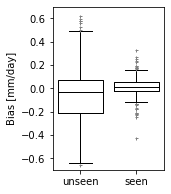

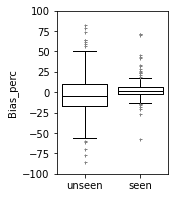

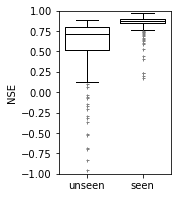

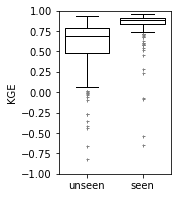

In [28]:
boxplot_metric('Bias [mm/day]', yrange=(-.7,.7))
boxplot_metric('Bias_perc', yrange=(-100,100))
boxplot_metric('NSE', yrange=(-1,1))
boxplot_metric('KGE', yrange=(-1,1))

/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


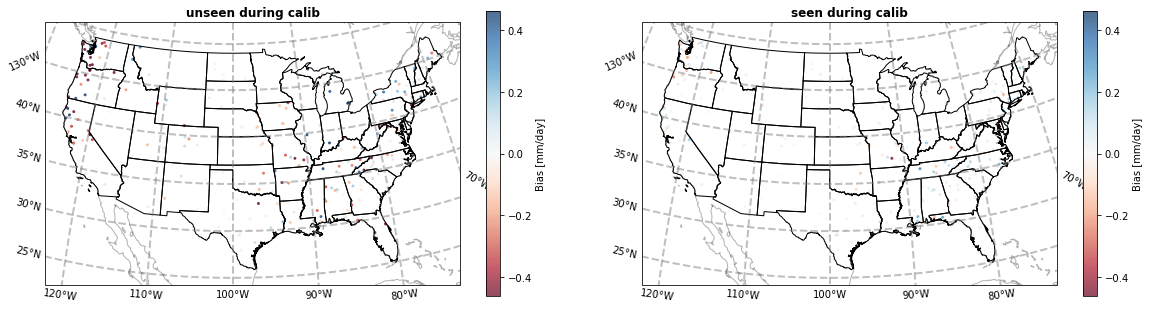

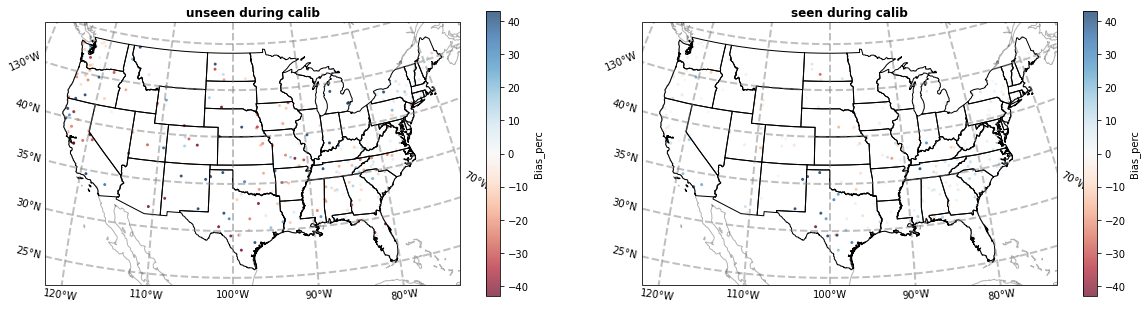

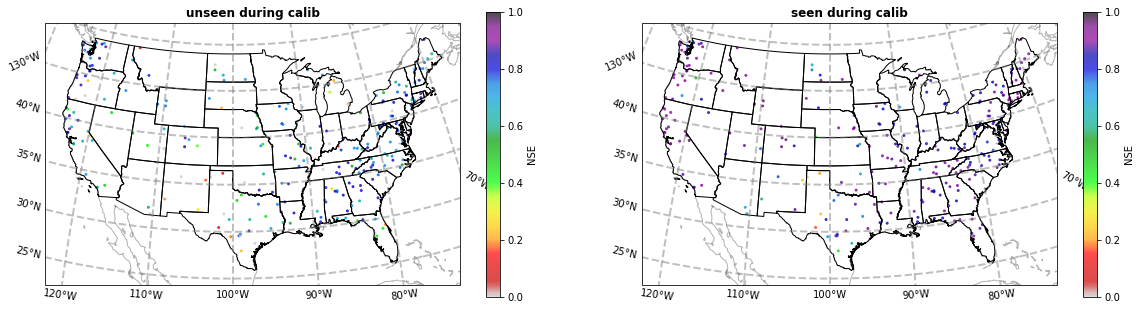

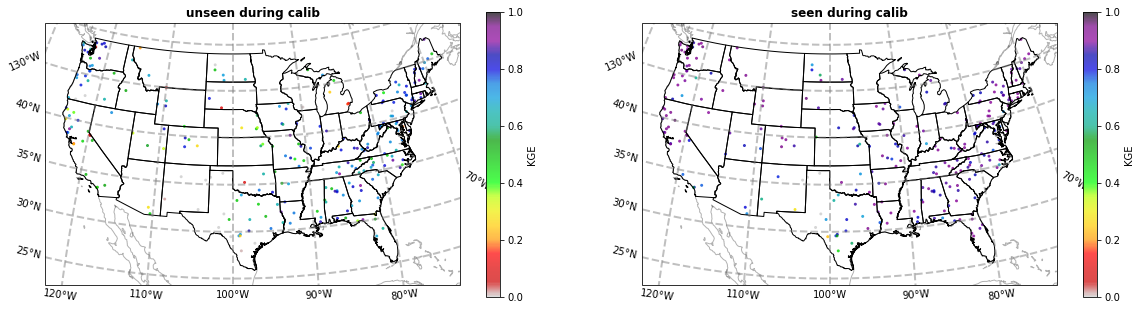

In [29]:
mapplot_metric('Bias [mm/day]', cmap='RdBu')
mapplot_metric('Bias_perc', cmap='RdBu')
mapplot_metric('NSE', cmap='nipy_spectral_r', crange=(0,1) )
mapplot_metric('KGE', cmap='nipy_spectral_r', crange=(0,1) )


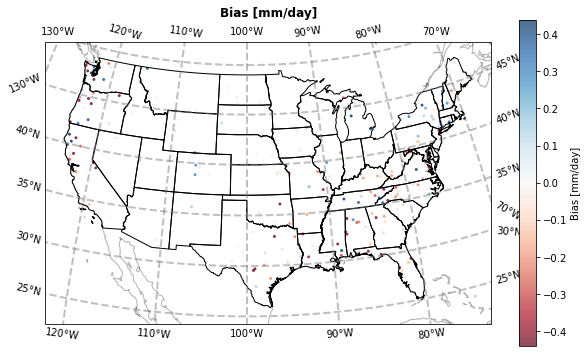

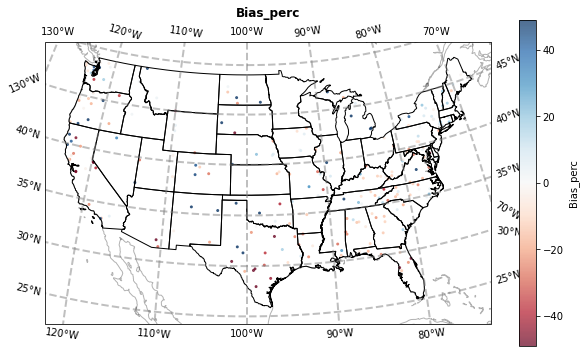

In [13]:
Metrics = Metrics_aorc

for varname in ['Bias [mm/day]', 'Bias_perc']:
    var = Metrics[varname]
    cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
    cmin = -1 * cmax
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='RdBu', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

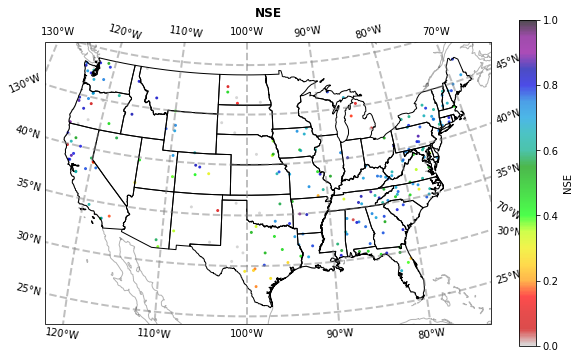

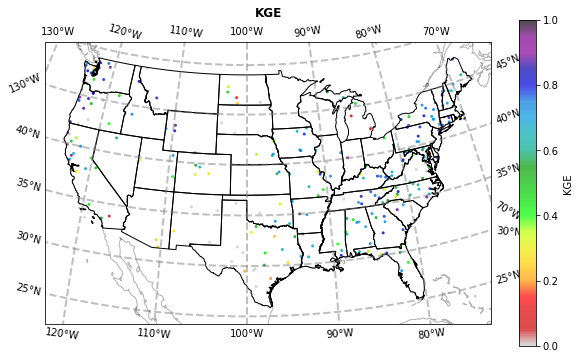

In [14]:
for varname in ['NSE', 'KGE']:
    var = Metrics[varname]
    cmin = 0
    cmax = 1
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())



### Hydrograph, single basin

In [31]:
Metrics.NSE.idxmax()

'07260000'

                qobs      qsim       err      %err
2000-10-01  4.153566  2.420229 -1.733337 -0.417313
2000-10-02  2.212531  1.837579 -0.374952 -0.169467
2000-10-03  1.802687  1.746867 -0.055821 -0.030965
2000-10-04  1.587363  1.501450 -0.085914 -0.054124
2000-10-05  1.443814  1.380430 -0.063384 -0.043901
...              ...       ...       ...       ...
2005-09-26  0.638690  0.796407  0.157717  0.246938
2005-09-27  0.671977  0.782758  0.110782  0.164859
2005-09-28  0.627248  0.765034  0.137786  0.219668
2005-09-29  2.609892  1.347866 -1.262025 -0.483555
2005-09-30  6.568938  2.099567 -4.469371 -0.680380

[1826 rows x 4 columns]


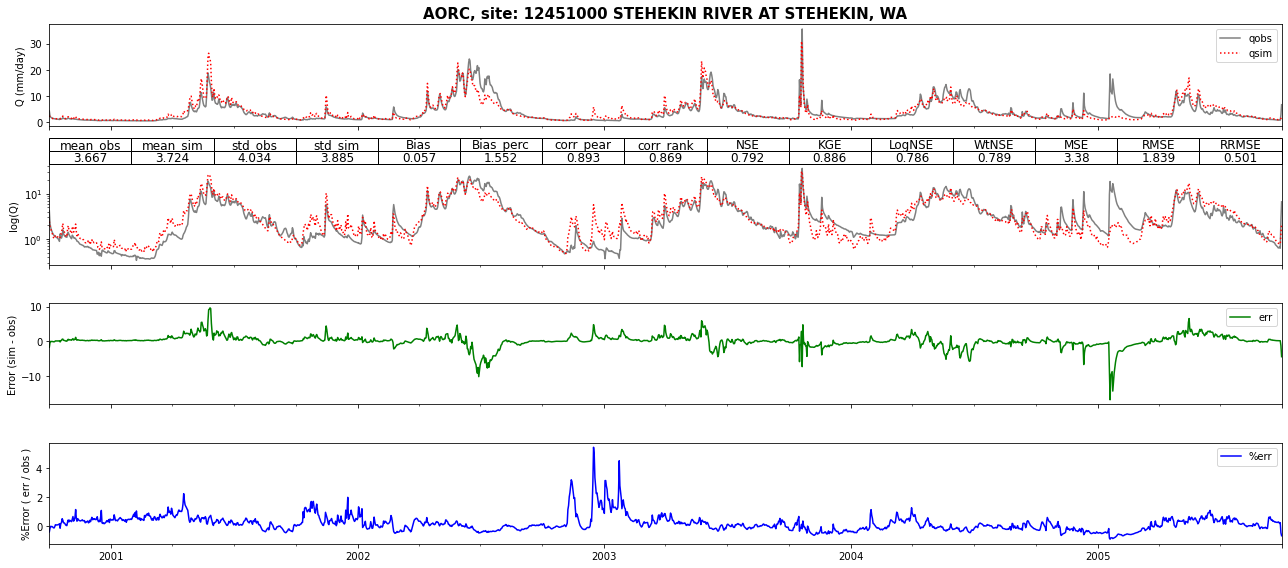

In [15]:
s = '12451000'
df = LSTM_aorc[s]
df['err'] = df.qsim - df.qobs
df['%err'] = df.err / df.qobs
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
print(df)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18,8))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
df.plot.line(ax=axes[2], y=['err'], color={"err":"green"}, style=['-'], legend=True).legend(loc='upper right')
df.plot.line(ax=axes[3], y=['%err'], color={"%err":"blue"}, style=['-'], legend=True).legend(loc='upper right')
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[2].set_ylabel('Error (sim - obs)')
axes[3].set_ylabel('%Error ( err / obs )')
axes[1].set_xlabel('Date')
axes[0].set_title('AORC, site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

In [17]:
diff = Metrics_aorc.NSE - Metrics_c404.NSE
diff[Metrics_c404.NSE>0].nlargest(20) #  idxmin()

site_no
08152900    0.7522
08400000    0.7283
08104900    0.7007
08408500    0.6808
08131400    0.6742
08186500    0.6726
07325860    0.6570
06893500    0.6478
08405105    0.6435
06853800    0.5876
09447800    0.5739
08086212    0.5709
02465493    0.5701
05494300    0.5671
06803510    0.5646
09485000    0.5460
06891810    0.5337
06803530    0.5273
08079600    0.5055
09484000    0.4925
Name: NSE, dtype: float64

In [42]:
Metrics_c404.NSE.idxmin()
Metrics_c404[Metrics_c404['station_nm'].str.contains(", TX")]

,station_nm,dec_lat_va,dec_long_va,mean_obs,mean_sim,std_obs,std_sim,Bias [mm/day],Bias_perc,corr_pear,...,LogNSE,WtNSE,MSE,RMSE,RRMSE,NSE_A,NSE_B,NSE_C,KGE_alpha,KGE_beta
site_no,,,,,,,,,,,,,,,,,,,,,
07227420,"Cramer Ck at US Hwy 54 nr Dalhart, TX",35.751250,-102.893167,0.0001,0.0043,0.0062,0.0094,0.0042,3692.8628,0.0695,...,-427.9360,-215.4006,0.0001,0.0122,108.2437,0.0048,2.1104,0.4499,1.5222,37.9286
07233500,"Palo Duro Ck nr Spearman, TX",36.202255,-101.305993,0.0032,0.0096,0.0626,0.0183,0.0064,202.1808,0.4984,...,-15.6982,-7.7514,0.0032,0.0562,17.7063,0.2484,0.0424,0.0105,0.2925,3.0218
07312200,"Beaver Ck nr Electra, TX",33.905928,-98.905067,0.0985,0.1232,0.4740,0.3942,0.0247,25.0461,0.8733,...,-0.4141,0.1721,0.0543,0.2330,2.3662,0.7627,0.0017,0.0027,0.8316,1.2505
07346045,"Black Cypress Bayou at Jefferson, TX",32.777917,-94.357415,0.7548,0.7673,1.6972,1.5735,0.0125,1.6560,0.9503,...,0.2739,0.5882,0.2808,0.5299,0.7020,0.9031,0.0005,0.0001,0.9271,1.0166
08029500,"Big Cow Ck nr Newton, TX",30.818889,-93.785556,0.9821,1.1161,4.4025,3.7092,0.1340,13.6481,0.8980,...,0.7011,0.7517,3.8302,1.9571,1.9928,0.8064,0.0031,0.0009,0.8425,1.1365
08057200,"White Rk Ck at Greenville Ave, Dallas, TX",32.889292,-96.756666,1.4737,1.4171,5.1808,4.6027,-0.0566,-3.8402,0.9360,...,0.6572,0.7654,3.3899,1.8412,1.2494,0.8761,0.0023,0.0001,0.8884,0.9616
08065200,"Upper Keechi Ck nr Oakwood, TX",31.569896,-95.888294,0.5021,0.5429,2.5555,1.8822,0.0408,8.1278,0.8697,...,0.4480,0.5932,1.7083,1.3070,2.6034,0.7563,0.0177,0.0003,0.7365,1.0813
08070500,"Caney Ck nr Splendora, TX",30.259658,-95.302436,0.6896,0.6733,3.4319,3.5017,-0.0162,-2.3537,0.9479,...,0.1854,0.5393,1.2574,1.1213,1.6261,0.8985,0.0052,0.0000,1.0203,0.9765
08082700,"Millers Ck nr Munday, TX",33.329266,-99.465082,0.1070,0.1409,0.9207,0.7736,0.0339,31.6272,0.8729,...,-0.7983,-0.0194,0.2038,0.4515,4.2183,0.7620,0.0011,0.0014,0.8402,1.3163


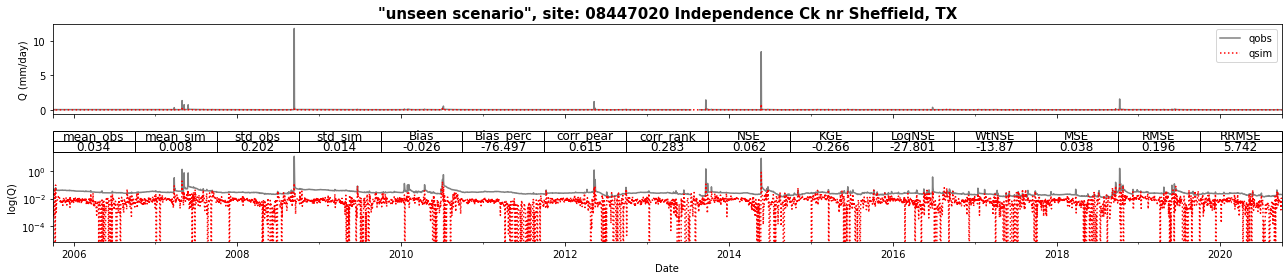

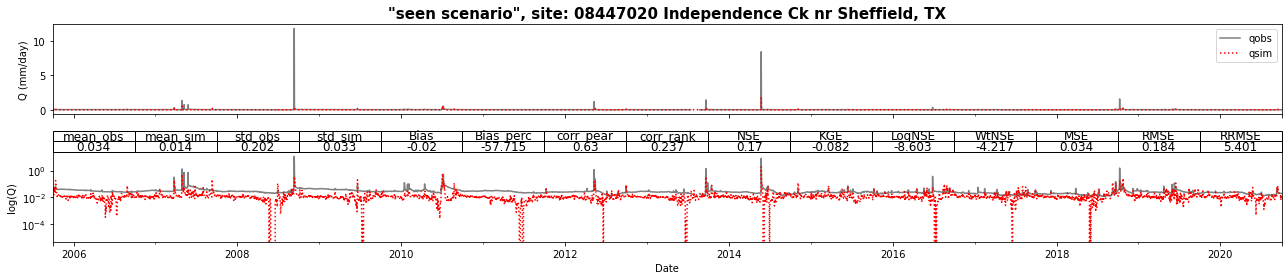

In [47]:
s = '08447020'

## First plot: AORC
df = LSTM_aorc[s]
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,4))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[1].set_xlabel('Date')
axes[0].set_title('"unseen scenario", site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

## Second plot: C404
df = LSTM_c404[s]
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,4))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[1].set_xlabel('Date')
axes[0].set_title('"seen scenario", site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

In [127]:
verif.iloc[:, :10]

,mean_obs,mean_sim,std_obs,std_sim,Bias,Bias_perc,corr_pear,corr_rank,NSE,KGE
0,2.701746,2.461445,5.144389,4.890418,-0.2403,-8.894261,0.94638,0.980782,0.893435,0.885008
